In [1]:
import pandas as pd

In [2]:
# Load airport-level daily data (weather + flights)
mart_ap_d_df = pd.read_csv('./csv_files/mart_airport_daily_milton.csv')
mart_ap_d_df.info()  # inspect schema and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   airport_code         155 non-null    object 
 1   date                 155 non-null    object 
 2   num_flights          155 non-null    int64  
 3   num_cancelled        155 non-null    int64  
 4   pct_cancelled        155 non-null    float64
 5   avg_dep_delay        141 non-null    float64
 6   peak_wind_speed_kmh  155 non-null    float64
 7   total_precip_mm      155 non-null    float64
 8   min_pressure_hpa     155 non-null    float64
 9   avg_temp_c           155 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.2+ KB


In [3]:
# Convert date column to datetime type for time-based operations
mart_ap_d_df['date'] = pd.to_datetime(mart_ap_d_df['date'])
print(mart_ap_d_df['date'].dtype) # confirm dtype change

datetime64[ns]


In [4]:
mart_ap_d_df.head()  # preview data

,airport_code,date,num_flights,num_cancelled,pct_cancelled,avg_dep_delay,peak_wind_speed_kmh,total_precip_mm,min_pressure_hpa,avg_temp_c
0,MCO,2024-10-05,380,3,0.008,4.88,20.5,0.0,1013.7,27.737500
1,SRQ,2024-10-14,42,42,1.000,NaN,18.4,0.0,1016.1,24.583333
2,TPA,2024-10-03,207,0,0.000,30.61,14.8,14.2,1011.1,28.087500
3,PIE,2024-10-07,28,7,0.250,17.67,27.7,8.4,1006.5,24.687500
4,TPA,2024-10-14,213,0,0.000,6.95,18.4,0.0,1016.3,24.729167


In [5]:
# Calculate the average number of flights per day per airport during the pre-storm baseline window (Oct 1–7)

In [6]:
# Define the pre-storm baseline window
baseline_start = "2024-10-01"
baseline_end = "2024-10-07"

# Filter data to baseline period and calculate average daily flights per airport
baseline_df = (
    mart_ap_d_df[mart_ap_d_df['date'].between(baseline_start, baseline_end)]
    .groupby('airport_code')['num_flights']
    .mean()
    .reset_index()
)

# Round and rename the column for clarity
baseline_df['num_flights'] = baseline_df['num_flights'].round()
baseline_df = baseline_df.rename(columns={'num_flights': 'baseline_flights'})

In [7]:
baseline_df

,airport_code,baseline_flights
0,DAB,8.0
1,MCO,375.0
2,PIE,21.0
3,SRQ,37.0
4,TPA,190.0


In [8]:
# Merge baseline values into full dataset to enable comparisons by date
df = mart_ap_d_df.merge(baseline_df, on='airport_code')

In [9]:
# Identify recovery milestones for each airport: 
# Reopened: when operations resumed at 50% of baseline and <50% cancellations
# Fully Recovered: when operations reached 90% of baseline and <5% cancellations

In [10]:
# Stage 1: Reopened — airport resumes meaningful operations
reopened_rows = df[
    (df['date'] >= "2024-10-10") &
    (df['pct_cancelled'] < 0.5) &  # fewer than half of flights canceled
    (df['num_flights'] >= 0.5 * df['baseline_flights'])  # at least 50% of baseline volume
]

first_reopened = (
    reopened_rows
    .groupby('airport_code')['date']
    .min()
    .reset_index()
    .rename(columns={'date': 'reopen_date'})
)

# Stage 2: Fully Recovered — near-normal operations resume
recovered_rows = df[
    (df['date'] >= "2024-10-10") &
    (df['pct_cancelled'] < 0.05) &  # nearly all scheduled flights operating
    (df['num_flights'] >= 0.9 * df['baseline_flights'])  # 90% of baseline volume
]

first_recovered = (
    recovered_rows
    .groupby('airport_code')['date']
    .min()
    .reset_index()
    .rename(columns={'date': 'recovery_date'})
)

In [11]:
first_reopened

,airport_code,reopen_date
0,DAB,2024-10-12
1,MCO,2024-10-11
2,PIE,2024-10-12
3,SRQ,2024-10-16
4,TPA,2024-10-11


In [12]:
first_recovered

,airport_code,recovery_date
0,DAB,2024-10-12
1,MCO,2024-10-12
2,PIE,2024-10-13
3,SRQ,2024-10-17
4,TPA,2024-10-12


In [13]:
# Merge reopening and recovery dates into a single summary
status_df = pd.merge(first_reopened, first_recovered, on='airport_code', how='left')
status_df

,airport_code,reopen_date,recovery_date
0,DAB,2024-10-12,2024-10-12
1,MCO,2024-10-11,2024-10-12
2,PIE,2024-10-12,2024-10-13
3,SRQ,2024-10-16,2024-10-17
4,TPA,2024-10-11,2024-10-12


In [14]:
# Now I will build resilience metrics table: 
# 1. Days to recovery
# 2. Total % of flights cancelled for Oct 2024
# 3. Highest hourly avg windspeed

In [15]:
# First I will calculate the days to reopen & days to recovery

In [16]:
# Define the storm impact start date
storm_date = pd.to_datetime("2024-10-09")

# Calculate both metrics
status_df['days_to_reopen'] = (status_df['reopen_date'] - storm_date).dt.days
status_df['days_to_recovery'] = (status_df['recovery_date'] - storm_date).dt.days

# Preview to confirm
status_df

,airport_code,reopen_date,recovery_date,days_to_reopen,days_to_recovery
0,DAB,2024-10-12,2024-10-12,3,3
1,MCO,2024-10-11,2024-10-12,2,3
2,PIE,2024-10-12,2024-10-13,3,4
3,SRQ,2024-10-16,2024-10-17,7,8
4,TPA,2024-10-11,2024-10-12,2,3


In [17]:
# Second I will calculate the % of flights cancelled in Oct 2024

In [18]:
monthly_stats = ( 
    df.groupby('airport_code')
    .agg({
        'num_flights': 'sum',
        'num_cancelled': 'sum'
    })
    .reset_index()
)

# Calculate percent of flights cancelled
monthly_stats['pct_cancelled_oct'] = (
    monthly_stats['num_cancelled'] / monthly_stats['num_flights']
).round(3)

monthly_stats

,airport_code,num_flights,num_cancelled,pct_cancelled_oct
0,DAB,239,19,0.079
1,MCO,12289,929,0.076
2,PIE,631,94,0.149
3,SRQ,1190,323,0.271
4,TPA,6051,634,0.105


In [19]:
# Finally I will calculate the peak wind speeds by airport

In [20]:
# Peak wind speed = highest hourly average wind speed recorded per airport
peak_wind = (
    df.groupby('airport_code')['peak_wind_speed_kmh']
    .max()
    .reset_index()
)

peak_wind

,airport_code,peak_wind_speed_kmh
0,DAB,100.1
1,MCO,74.2
2,PIE,90.4
3,SRQ,117.0
4,TPA,83.5


In [21]:
# Combine recovery data, cancellation rate, and peak wind speed into a single dataset
resilience_df = (
    status_df
    .merge(monthly_stats[['airport_code', 'pct_cancelled_oct']], on='airport_code')
    .merge(peak_wind, on='airport_code')
)
resilience_df

,airport_code,reopen_date,recovery_date,days_to_reopen,days_to_recovery,pct_cancelled_oct,peak_wind_speed_kmh
0,DAB,2024-10-12,2024-10-12,3,3,0.079,100.1
1,MCO,2024-10-11,2024-10-12,2,3,0.076,74.2
2,PIE,2024-10-12,2024-10-13,3,4,0.149,90.4
3,SRQ,2024-10-16,2024-10-17,7,8,0.271,117.0
4,TPA,2024-10-11,2024-10-12,2,3,0.105,83.5


In [22]:
# Resilience Score Calculation

# The goal of this formula was to evaluate how effectively each airport recovered from Hurricane Milton.
# After exploring multiple options, I needed a score that fairly balanced:
#   - the intensity of the storm each airport experienced
#   - the speed and efficiency of operational recovery

# Original attempts used raw wind speed in the denominator,
# but this unintentionally favored airports with extreme wind conditions-—even if they recovered poorly.

# To correct this, I applied the square root to peak wind speed.
# This still rewards resilience in stronger storms, but dampens the disproportionate benefit from extreme values.

# The numerator combines:
#   - days_to_recovery: how many days the airport took to return to baseline
#   - pct_cancelled_oct: the overall disruption in October, scaled by a factor of 10 to match recovery days on a similar scale

In [23]:
# Final formula: lower scores indicate better resilience (fast recovery and minimal cancellations)
resilience_df['resilience_score'] = (
    (resilience_df['days_to_recovery'] + 
     (resilience_df['pct_cancelled_oct'] * 10)) /
    (resilience_df['peak_wind_speed_kmh'] ** 0.5 / 10)
).round(2)
# Rank by resilience (lower score is more resilient)
resilience_df = resilience_df.sort_values('resilience_score', ascending=True)

In [24]:
resilience_df

,airport_code,reopen_date,recovery_date,days_to_reopen,days_to_recovery,pct_cancelled_oct,peak_wind_speed_kmh,resilience_score
0,DAB,2024-10-12,2024-10-12,3,3,0.079,100.1,3.79
1,MCO,2024-10-11,2024-10-12,2,3,0.076,74.2,4.37
4,TPA,2024-10-11,2024-10-12,2,3,0.105,83.5,4.43
2,PIE,2024-10-12,2024-10-13,3,4,0.149,90.4,5.77
3,SRQ,2024-10-16,2024-10-17,7,8,0.271,117.0,9.90


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

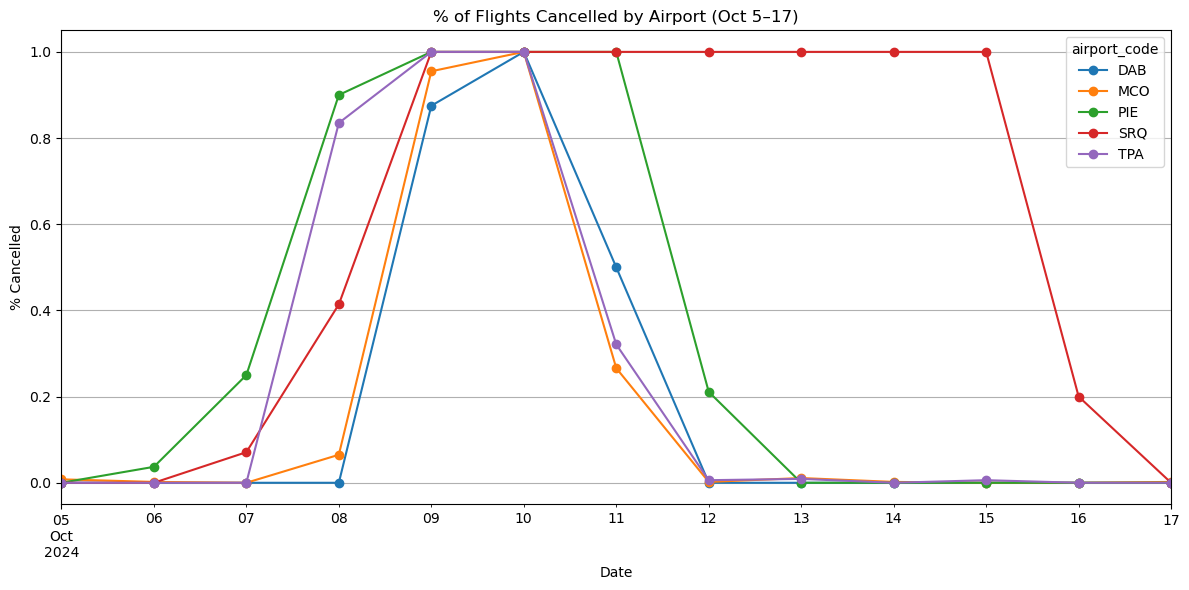

In [26]:
# Quick test plot to visualize % of flight cancellations around hurricane landfall
test_df = df[
    (df['date'] >= '2024-10-05') &
    (df['date'] <= '2024-10-17')
].copy()

# Pivot to wide format for line plotting
pivot_df = test_df.pivot(index='date', columns='airport_code', values='pct_cancelled')

pivot_df.plot(
    figsize=(12, 6),
    marker='o',
    title="% of Flights Cancelled by Airport (Oct 5–17)",
    ylabel="% Cancelled",
    xlabel="Date",
    grid=True
)
plt.tight_layout()

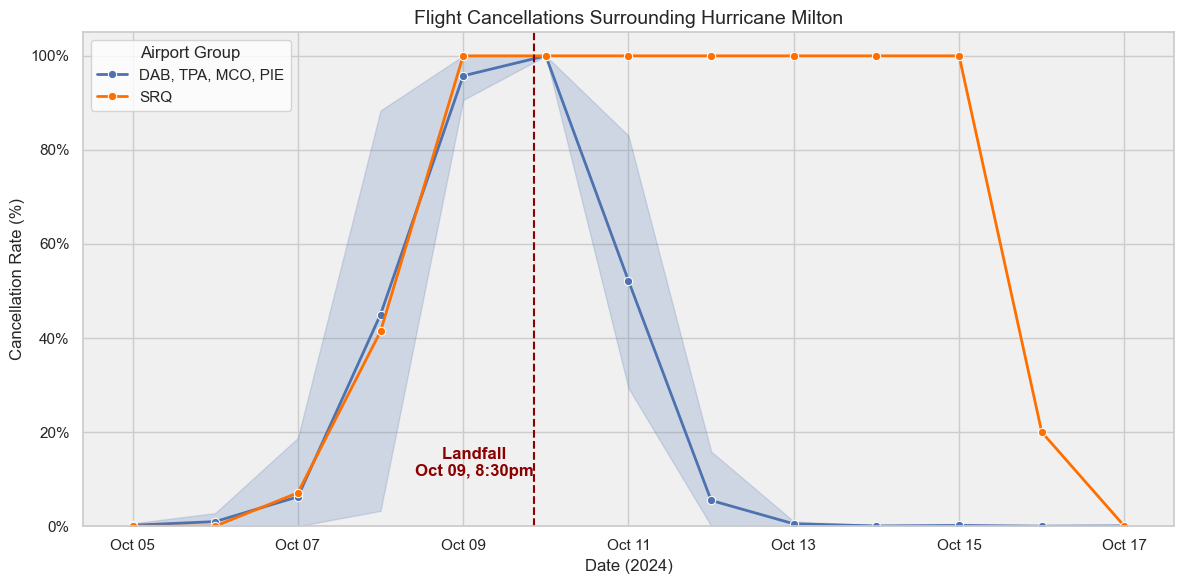

In [27]:
# Create upgraded, more detailed version in seaborn

plot_df = df[                                       # Filter for Oct 5–17
    (df['date'] >= '2024-10-05') &                  
    (df['date'] <= '2024-10-17')
].copy()

# Highlight SRQ vs. other airports to show relative cancellation behavior
plot_df['highlight'] = plot_df['airport_code'].apply(
    lambda x: 'SRQ' if x == 'SRQ' else 'DAB, TPA, MCO, PIE'
)

sns.set_theme(style="whitegrid")                    # Set Seaborn theme
fig, ax = plt.subplots(figsize=(12, 6))             # Create figure and axis
ax.set_facecolor('#f0f0f0')                         # Light grey background inside plot

sns.lineplot(                                       # Line plot showing cancellation rate trends
    data=plot_df,
    x="date",
    y="pct_cancelled",
    hue="highlight",
    palette={
        "SRQ": "#FF6F00",                           # Highlight color for SRQ
        "DAB, TPA, MCO, PIE": "#4C72B0"
    },
    linewidth=2,
    marker="o",
    ax=ax
)

# Add hurricane landfall marker
landfall = pd.to_datetime("2024-10-09 20:30")
ax.axvline(landfall, color='darkred', linestyle='--', linewidth=1.5)
ax.text(landfall, 0.1, 'Landfall      \nOct 09, 8:30pm', ha='right', va='bottom', color='darkred', weight='bold')

# Titles and labels
ax.set_title("Flight Cancellations Surrounding Hurricane Milton", fontsize=14)
ax.set_xlabel("Date (2024)")
ax.set_ylabel("Cancellation Rate (%)")

# Y-axis formatting (percent style)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
ax.set_ylim(0, 1.05)

# X-axis date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Legend and layout
ax.legend(title="Airport Group", loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
# Daily flight cancellations from Oct 5–17 across five Florida airports.
# Hurricane Milton made landfall on Oct 9 (dashed line).
# While some airports recovered within days, SRQ remained heavily impacted long after the storm passed.

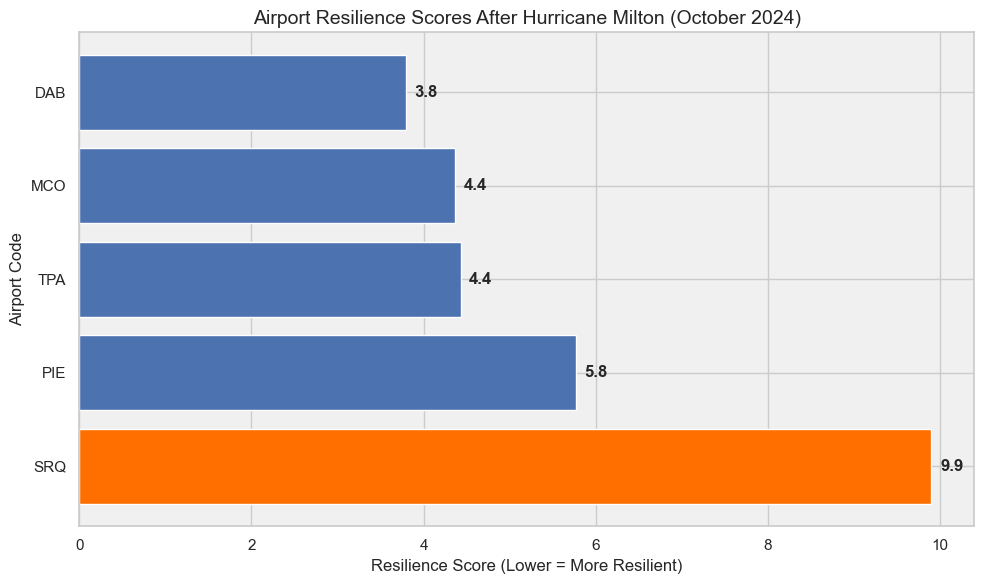

In [29]:
# Bar chart: Resilience score by airport after Hurricane Milton

# Sort airports by resilience score (lower = better)
res_plot = resilience_df.sort_values('resilience_score', ascending=True).copy()

# Set up colors: highlight SRQ
bar_colors = ['#FF6F00' if code == 'SRQ' else '#4C72B0' for code in res_plot['airport_code']]

fig, ax = plt.subplots(figsize=(10, 6))             # Create figure and axes
ax.set_facecolor('#f0f0f0')                         # Light grey background inside chart

bars = ax.barh(                                     # Draw horizontal bars
    y=res_plot['airport_code'],
    width=res_plot['resilience_score'],
    color=bar_colors
)

# Annotate scores next to each bar
for i, (score, airport) in enumerate(zip(res_plot['resilience_score'], res_plot['airport_code'])):
    ax.text(score + 0.1, i, f"{score:.1f}", va='center', weight='bold')

# Title and axis labels
ax.set_title('Airport Resilience Scores After Hurricane Milton (October 2024)', fontsize=14)
ax.set_xlabel('Resilience Score (Lower = More Resilient)', fontsize=12)
ax.set_ylabel('Airport Code', fontsize=12)
ax.invert_yaxis()                                   # Airports with best scores appear at the top

plt.tight_layout()
plt.show()

In [30]:
# Each bar represents a resilience score for airports affected by Hurricane Milton (October 2024).
# The score combines time to recovery and scaled cancellation rate, normalized by the square root of peak wind speed (maximum hourly average).
# SRQ, which faced the strongest impact and infrastructure damage, remained closed significantly longer than its peers — resulting in the highest (worst) resilience score.

In [31]:
# Prepare a polished summary table for export & README inclusion
recovery_table = resilience_df.copy()

# Rename columns for readability
recovery_table = recovery_table.rename(columns={
    'airport_code': 'Airport',
    'reopen_date': 'Date Reopened',
    'recovery_date': 'Date Recovered',
    'days_to_reopen': 'Days to Reopen',
    'days_to_recovery': 'Days to Recovery',
    'pct_cancelled_oct': '% Flights Cancelled (Oct)',
    'peak_wind_speed_kmh': 'Peak Wind (km/h)',
    'resilience_score': 'Resilience Score'
})

# Format numeric columns
recovery_table['% Flights Cancelled (Oct)'] = (recovery_table['% Flights Cancelled (Oct)'] * 100).round(1)
recovery_table['Resilience Score'] = recovery_table['Resilience Score'].round(2)
recovery_table['Peak Wind (km/h)'] = recovery_table['Peak Wind (km/h)'].round(1)

# Sort for presentation
recovery_table = recovery_table.sort_values('Resilience Score').reset_index(drop=True)

recovery_table

,Airport,Date Reopened,Date Recovered,Days to Reopen,Days to Recovery,% Flights Cancelled (Oct),Peak Wind (km/h),Resilience Score
0,DAB,2024-10-12,2024-10-12,3,3,7.9,100.1,3.79
1,MCO,2024-10-11,2024-10-12,2,3,7.6,74.2,4.37
2,TPA,2024-10-11,2024-10-12,2,3,10.5,83.5,4.43
3,PIE,2024-10-12,2024-10-13,3,4,14.9,90.4,5.77
4,SRQ,2024-10-16,2024-10-17,7,8,27.1,117.0,9.90


In [32]:
# Export the cleaned-up dataframe as .csv
# recovery_table.to_csv("csv_files/airport_resilience_summary.csv", index=False)